In [1]:
import os
import sys

# Get the parent directory of the current working directory
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to PYTHONPATH if it's not already there
if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

# Optionally verify
print("Parent directory added to PYTHONPATH:", parent_path)
print("Current PYTHONPATH:", sys.path)

from src.models.nnc2p import NNC2P
from src.utils.helpers import get_device
from src.training.train import get_model
from src.utils.arg_parser import parse_args_and_config
from src.data.data_generator import HybridPiecewiseDataGenerator, TabulatedDataGenerator, HybridPiecewiseDataGenerator_3D

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset

import numpy as np


Parent directory added to PYTHONPATH: /home/astro/miler/codes/c2p_ML
Current PYTHONPATH: ['/home/astro/miler/codes/c2p_ML', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python310.zip', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python3.10', '/home/astro/miler/.pyenv/versions/3.10.15/lib/python3.10/lib-dynload', '', '/scratch/astro/miler/python-env/pytorch/lib/python3.10/site-packages']


In [2]:
device = get_device()
model = torch.jit.load("../models/NNC2PS.pth")
model = model.to(device)
model.eval()
#model.load_state_dict(weights)
print(model)

RecursiveScriptModule(
  original_name=NNC2P
  (network): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)


I generate my data first with the model from the data and then inverse it both with the neural net, and the inversion

In [3]:
config = {
    "model": {
        "name": "NNC2PS",
        "input_dim": 3,
        "hidden_dims": [600, 200],
        "output_dim": 1
    },
    "training": {
        "batch_size": 32,
        "num_epochs": 85,
        "learning_rate": 3e-4,
        "penalty_factor": 150.0,
        "validation_split": 0.05,
        "test_split": 0.05
    },
    "data": {
        "n_samples": 50000,
        "gamma_th": 1.666667,  # 5/3
        "rho_min": 2.0e-5,
        "rho_max": 2.0e-3,
        "vx_max": 0.721,
        "eps_min": 0,
        "eps_max": 2,
        "K": [8.9493e-02, None, None, None],
        "Gamma": [1.3569, 3.0050, 2.9880, 2.8510],
        "rho_breaks": [2.3674e-04, 8.1147e-04, 1.6191e-03]
    },
    "paths": {
        "models": "models",
        "images": "images",
        "eos_tables": "eos_tables"
    }
}
def get_data_generator(config):
    model_name = config["model"]["name"]
    if model_name in ["NNC2PS", "NNC2PL"]:
        return HybridPiecewiseDataGenerator(config)
    elif model_name == "NNC2P_Tabulated":
        return TabulatedDataGenerator(config)
    elif model_name in ["NNC2PS_3D"]:
        return HybridPiecewiseDataGenerator_3D(config)
    else:
        raise ValueError(f"Unknown model type for data generation: {model_name}")
# Ensure required directories exist
device = get_device()
data_generator = get_data_generator(config)
train_loader, val_loader, test_loader = data_generator.get_data_loaders()
combined_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset, test_loader.dataset])
print("Number of training samples:", len(combined_dataset))

Number of training samples: 50000


EY rho tensor(2.0000e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(3.7649e-08)
EY eps_cold tensor(0.0053)
EY rho tensor(2.3968e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(4.8129e-08)
EY eps_cold tensor(0.0056)
EY rho tensor(2.7936e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(5.9250e-08)
EY eps_cold tensor(0.0059)
EY rho tensor(3.1904e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(7.0950e-08)
EY eps_cold tensor(0.0062)
EY rho tensor(3.5872e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(8.3183e-08)
EY eps_cold tensor(0.0065)
EY rho tensor(3.9840e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(9.5909e-08)
EY eps_cold tensor(0.0067)
EY rho tensor(4.3808e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(1.0910e-07)
EY eps_cold tensor(0.0070)
EY rho tensor(4.7776e-05)
EY, K, Gamma, A_i 0.089493 1.3569 0.0
EY press cold tensor(1.2272e-07)
EY eps_cold tensor(0.0072)
EY rho t

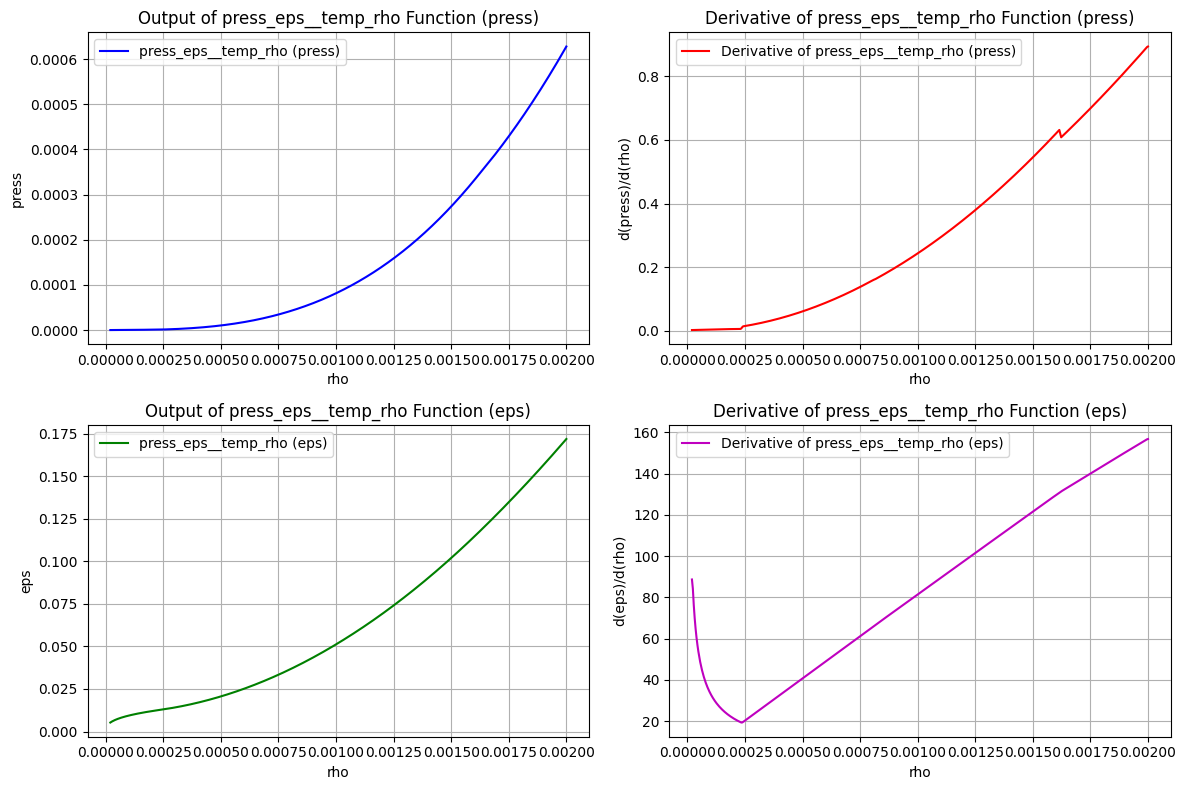

In [4]:
#Small tests for data_generator
import matplotlib.pyplot as plt

# Define the rho range
rho_min = 2.0e-5
rho_max = 2.0e-3
rho_values = torch.linspace(rho_min, rho_max, 500)  # Generate 500 points in the range

# Placeholder for results
press_values = []
eps_values = []

# Assuming data_generator.press_eps__temp_rho exists
# and the first argument is constant (e.g., 0.0 in your example)
constant_arg = torch.tensor(0.0)

# Compute the output for each rho value
for rho in rho_values:
    press, eps = data_generator.press_eps__temp_rho(constant_arg, rho)
    press_values.append(press.item())  # Convert tensor to scalar
    eps_values.append(eps.item())     # Convert tensor to scalar

# Convert results to numpy arrays for plotting
rho_values_np = rho_values.numpy()
press_values_np = np.array(press_values)
eps_values_np = np.array(eps_values)

# Compute the numerical derivatives
derivative_press = np.gradient(press_values_np, rho_values_np)
derivative_eps = np.gradient(eps_values_np, rho_values_np)

# Plotting the results for press
plt.figure(figsize=(12, 8))

# Original function: press
plt.subplot(2, 2, 1)
plt.plot(rho_values_np, press_values_np, label='press_eps__temp_rho (press)', color='b')
plt.xlabel('rho')
plt.ylabel('press')
plt.title('Output of press_eps__temp_rho Function (press)')
plt.grid(True)
plt.legend()

# Derivative plot: press
plt.subplot(2, 2, 2)
plt.plot(rho_values_np, derivative_press, label='Derivative of press_eps__temp_rho (press)', color='r')
plt.xlabel('rho')
plt.ylabel('d(press)/d(rho)')
plt.title('Derivative of press_eps__temp_rho Function (press)')
plt.grid(True)
plt.legend()

# Plotting the results for eps
# Original function: eps
plt.subplot(2, 2, 3)
plt.plot(rho_values_np, eps_values_np, label='press_eps__temp_rho (eps)', color='g')
plt.xlabel('rho')
plt.ylabel('eps')
plt.title('Output of press_eps__temp_rho Function (eps)')
plt.grid(True)
plt.legend()

# Derivative plot: eps
plt.subplot(2, 2, 4)
plt.plot(rho_values_np, derivative_eps, label='Derivative of press_eps__temp_rho (eps)', color='m')
plt.xlabel('rho')
plt.ylabel('d(eps)/d(rho)')
plt.title('Derivative of press_eps__temp_rho Function (eps)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Now lets input the data into the model

In [5]:
# Initialize lists to hold the predictions and labels
predictions = []
labels = []

# Set model to evaluation mode to disable dropout and batch norm updates
model.eval()

# Avoid tracking gradients during inference
with torch.no_grad():  
    for i, sample in enumerate(combined_dataset):
        inputs, label = sample  # Assuming the dataset returns a tuple (inputs, label)

        # Move data to the correct device (GPU or CPU)
        inputs, label = inputs.to(device), label.to(device)

        # Forward pass through the model
        output = model(inputs)

        # Collect predictions and labels
        predictions.append(output)
        labels.append(label)

        # Print progress every 10,000 samples
        if (i + 1) % 10000 == 0:
            print(f"Predicted {i + 1} samples")

# After the loop, convert predictions and labels to tensors (if necessary)
predictions = torch.cat(predictions)  # Concatenate all predictions into one tensor
labels = torch.cat(labels)            # Concatenate all labels into one tensor

# Ensure everything is on the same device (if needed)
predictions = predictions.to(device)
labels = labels.to(device)

print(f"Completed predictions for {len(predictions)} samples.")


Predicted 10000 samples
Predicted 20000 samples
Predicted 30000 samples
Predicted 40000 samples
Predicted 50000 samples
Completed predictions for 50000 samples.


In [24]:
#tau = []
#stilde = []
#dens = []
#for input, output in combined_dataset:
#    tau.append(input[0].item())
#    stilde.append(input[1].item()) 
#    dens.append(input[2].item())
print(train_loader)

input, output =data_generator.recover_data_from_dataloader(train_loader)

[[0.001869   0.00014319 0.00153391]
 [0.00076685 0.00065972 0.00100382]
 [0.00252763 0.00468271 0.00369513]
 ...
 [0.00193303 0.000488   0.00108028]
 [0.00074182 0.00054175 0.00038386]
 [0.00084302 0.00186293 0.00188125]]
[[0.00134801]
 [0.00058301]
 [0.0012639 ]
 ...
 [0.00104436]
 [0.00016174]
 [0.00068041]]


In [7]:
# Assuming predictions and labels are in tensor form

# 1. Calculate error in ML units (Mean Squared Error and Mean Absolute Error)

# Mean Squared Error (MSE)
mse = torch.mean((predictions - labels) ** 2)
# Mean Absolute Error (MAE)
mae = torch.mean(torch.abs(predictions - labels))

print(f"MSE in ML units: {mse.item()}")
print(f"MAE in ML units: {mae.item()}")

# 2. If you applied normalization or scaling, reverse the transformations
# Example: Let's assume the data was normalized with mean and std
mean = 5.0  # Example mean used during normalization
std = 2.0   # Example std used during normalization

# If the predictions and labels were normalized, we need to transform them back:
# For normalized data: x_original = x_normalized * std + mean

# Reverse the MSE and MAE to original units:
# For MSE, we scale it by the square of the standard deviation (because MSE involves squaring the errors)
mse_original_units = mse * (std ** 2)

# For MAE, we scale it directly by the standard deviation
mae_original_units = mae * std

print(f"MSE in original units: {mse_original_units.item()}")
print(f"MAE in original units: {mae_original_units.item()}")

MSE in ML units: 6.785814184695482e-05
MAE in ML units: 0.006734319496899843
MSE in original units: 0.0002714325673878193
MAE in original units: 0.013468638993799686


In [25]:
import importlib
from src.data.c2p import *
from src.data.metric import *
importlib.reload(sys.modules['src.data.c2p'])
importlib.reload(sys.modules['src.data.metric'])
importlib.reload(sys.modules['src.data.data_generator'])

eta = metric(np.eye(3), np.zeros(3), 1)
prims = []
print(dens)
for i in range(len(input)):
        cc = conservs(input[i,],np.array((stilde[i],0,0)),tau[i]) #this s needed for the one dimensional case
        #  Finally invert to find the correct answer
        inverter = c2p(eta,cc,data_generator)
        print("What")
        prims_tmp , _ = inverter.invert()
        prims.append(prims_tmp)
print(prims)

[-0.7641134858131409, -0.5401363968849182, 0.12467735260725021, -0.7558799386024475, -0.5388831496238708, 0.628576934337616, -0.29717838764190674, 3.681960344314575, 0.971145510673523, -0.3449964225292206, -0.8242080807685852, 0.032941486686468124, 0.769202709197998, -0.9438385367393494, -0.9812788963317871, 1.0167139768600464, -0.9720662236213684, -0.9255390763282776, 0.5402334928512573, -0.6238133311271667, 0.6164059638977051, 0.19379369914531708, -0.4407713711261749, -0.17702405154705048, -0.15125727653503418, -0.1327078640460968, -0.12293867021799088, -0.24150070548057556, -0.616261899471283, -0.8498463034629822, -0.6843879818916321, -0.9557210206985474, 0.2396538406610489, 0.9033615589141846, 0.8088740110397339, 1.0608198642730713, 0.47002875804901123, -0.4851490557193756, 0.03416205570101738, -0.02968727797269821, 2.810164451599121, -0.8637928366661072, -0.6672842502593994, -0.8519231081008911, -0.7198851108551025, 0.44179391860961914, 1.491495132446289, 1.665809988975525, 0.9459

TypeError: list indices must be integers or slices, not tuple

In [ ]:
import importlib
from src.data.c2p import *
from src.data.metric import *
importlib.reload(sys.modules['src.data.c2p'])
importlib.reload(sys.modules['src.data.metric'])
importlib.reload(sys.modules['src.data.data_generator'])

eta = metric(np.eye(3), np.zeros(3), 1)
prims = []
print(dens)
for i in range(len(dens)):
        cc = conservs(dens[i],np.array((stilde[i],0,0)),tau[i]) #this s needed for the one dimensional case
        #  Finally invert to find the correct answer
        inverter = c2p(eta,cc,data_generator)
        print("What")
        prims_tmp , _ = inverter.invert()
        prims.append(prims_tmp)
print(prims)

[-0.4623482823371887, -0.6832836270332336, -0.870933473110199, -0.7693419456481934, -0.7126643657684326, -0.8729051351547241, -0.9964010715484619, -0.7138382196426392, 1.4780486822128296, -0.9619132876396179, -1.0145748853683472, -1.0202724933624268, -0.6265789866447449, -0.6838201284408569, -0.2648237943649292, -1.037926197052002, 0.19904884696006775, 0.5782310366630554, -0.6530013680458069, -0.7614665627479553, -0.9996355175971985, -0.9689915180206299, -0.7395727038383484, 3.481679916381836, -0.125171959400177, 1.8864318132400513, 2.3752243518829346, -0.2637278139591217, -0.4908621609210968, -0.15544383227825165, 1.8446552753448486, 1.2365844249725342, -0.32882076501846313, 2.554551839828491, -0.6666482090950012, -0.8159818649291992, -0.3764459192752838, -0.032994840294122696, -0.9030730128288269, 0.17216862738132477, -0.6856263875961304, 0.5709549784660339, -0.4358205497264862, 0.8767362833023071, -1.0132027864456177, -0.5238024592399597, -0.7349230647087097, 0.10010238736867905, 0.

ValueError: The function value at x=0.08194136621605866 is NaN; solver cannot continue.

Object `signs` not found.
